In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.datasets import mnist

In [6]:
(x_train, _), (x_test, _) = mnist.load_data()

In [7]:
# normalize the image data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [8]:
# reshape in the input data for the model
x_train = x_train.reshape(len(x_train), 28, 28, 1)
x_test = x_test.reshape(len(x_test), 28, 28, 1)
x_test.shape

(10000, 28, 28, 1)

#### Adding noise to the image

In [11]:
# add noise
noise_factor = 0.6
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [12]:
# clip the values in the range of 0-1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#### EDA

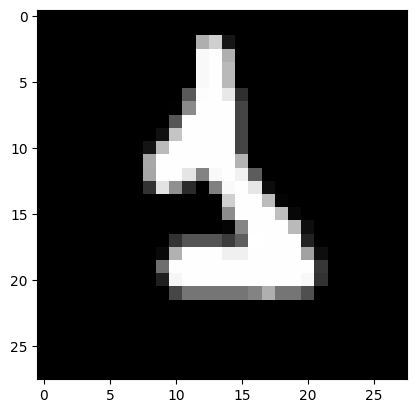

In [13]:
# randomly select input image
index = np.random.randint(len(x_test))
# plot the image
plt.imshow(x_test[index].reshape(28,28))
plt.gray()

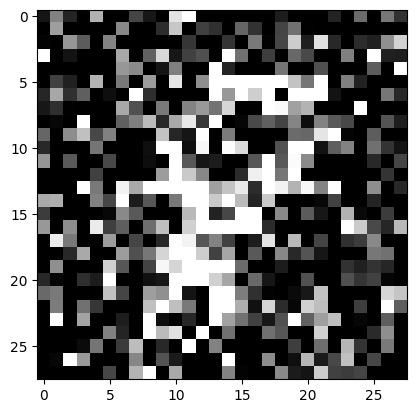

In [14]:
# randomly select input image
index = np.random.randint(len(x_test))
# plot the image
plt.imshow(x_test_noisy[index].reshape(28,28))
plt.gray()

#### Model training

In [31]:
import tensorflow as tf
with tf.device('/cpu:0'):
    model = Sequential([
                        # encoder network
                        Conv2D(56, 3, activation='relu', padding='same', input_shape=(28, 28, 1)),
                        MaxPooling2D(2, padding='same'),
                        Conv2D(14, 3, activation='relu', padding='same'),
                        MaxPooling2D(2, padding='same'),
        
                        # decoder network
                        Conv2D(14, 3, activation='relu', padding='same'),
                        UpSampling2D(2),
                        Conv2D(56, 3, activation='relu', padding='same'),
                        UpSampling2D(2),
        
                        # output layer
                        Conv2D(1, 3, activation='sigmoid', padding='same')
    ])

    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 56)        560       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 56)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 14)        7070      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 14)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 14)          1778      
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 14)      

In [32]:
with tf.device('/cpu:0'):
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=5,            # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the best weights after stopping
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Metric to monitor
    factor=0.5,             # Factor by which the learning rate will be reduced
    patience=3,             # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-6,             # Minimum learning rate
    verbose=1
)

In [34]:
history = model.fit(x_train_noisy, x_train, batch_size=32, epochs=200, validation_data=(x_test_noisy, x_test),
                    callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/200
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1484 - accuracy: 0.8065 - val_loss: 0.1222 - val_accuracy: 0.8093 - lr: 0.0010
Epoch 2/200
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1202 - accuracy: 0.8103 - val_loss: 0.1164 - val_accuracy: 0.8097 - lr: 0.0010
Epoch 3/200
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1159 - accuracy: 0.8110 - val_loss: 0.1139 - val_accuracy: 0.8094 - lr: 0.0010
Epoch 4/200
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1136 - accuracy: 0.8113 - val_loss: 0.1115 - val_accuracy: 0.8106 - lr: 0.0010
Epoch 5/200
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1122 - accuracy: 0.8114 - val_loss: 0.1106 - val_accuracy: 0.8107 - lr: 0.0010
Epoch 6/200
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1114 - accuracy: 0.8115 - val_loss: 0.1106 - val_accuracy: 0.8099 - lr: 0.0010
Epoch 7/200
1875/1875 [=======================

In [35]:
# Extract accuracy and loss from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

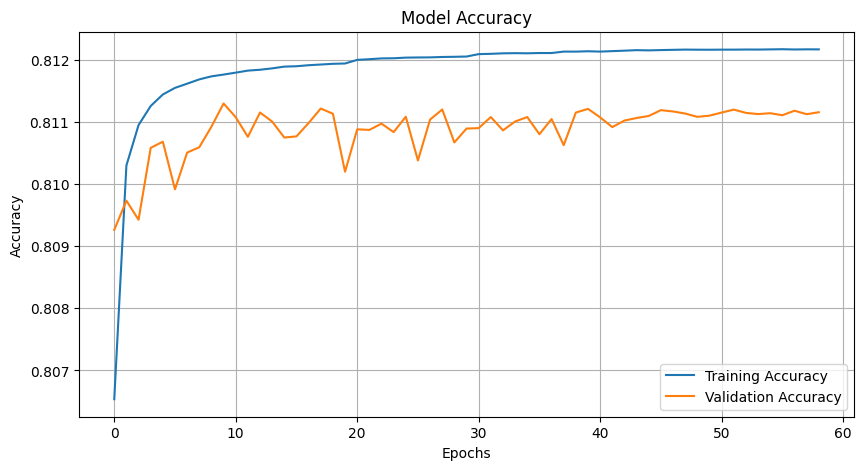

In [36]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

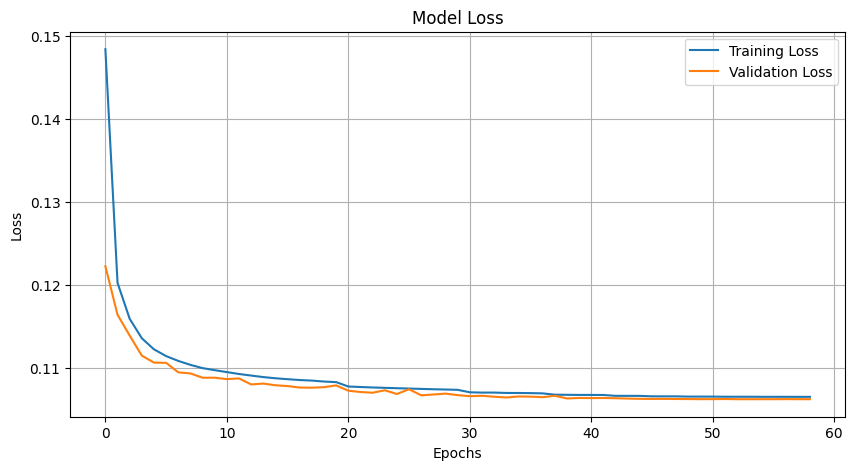

In [37]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [38]:
pred = model.predict(x_test_noisy)

313/313 [==============================] - 1s 3ms/step


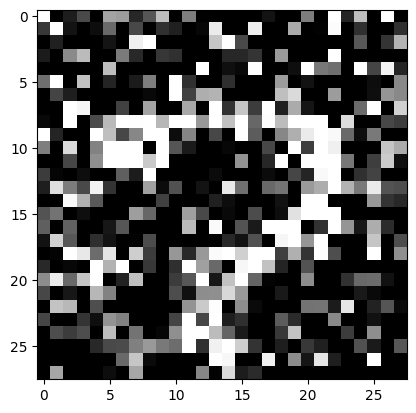

In [39]:
# randomly select input image
index = np.random.randint(len(x_test))
# plot the image
plt.imshow(x_test_noisy[index].reshape(28,28))
plt.gray()

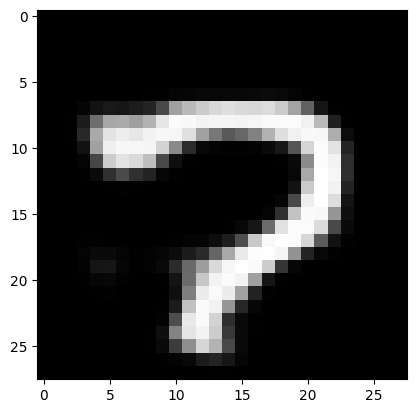

In [40]:
# visualize compressed image
plt.imshow(pred[index].reshape(28,28))
plt.gray()

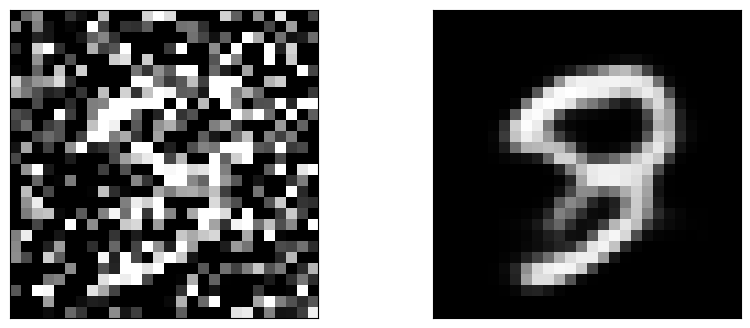

In [41]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(10, 4))
# display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(x_test_noisy[index].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# display compressed image
ax = plt.subplot(1, 2, 2)
plt.imshow(pred[index].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

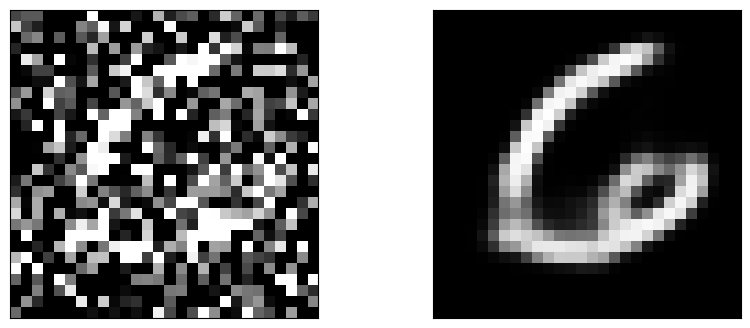

In [42]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(10, 4))
# display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(x_test_noisy[index].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# display compressed image
ax = plt.subplot(1, 2, 2)
plt.imshow(pred[index].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()